In [1]:
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# tensorflow and related layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

# reports
from sklearn.metrics import confusion_matrix, classification_report

# progress status
from tqdm.notebook import tqdm

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.5.0
Keras version: 2.5.0


In [3]:
tf_memory_limit = 1024
gpus = tf.config.experimental.list_physical_devices("GPU")
print("Tensorflow initialization. Memory limit: ", (-1 if tf_memory_limit is None else tf_memory_limit))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        if tf_memory_limit is not None:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=tf_memory_limit)])
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print("Physical GPUs {}, Logical GPUs {}".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

Tensorflow initialization. Memory limit:  1024
Physical GPUs 2, Logical GPUs 2


Define Model parameters

In [4]:
model_params = {
    "n_epochs": 20,
    "batch_size": 32,
    "activation_output": "softmax",
    "loss": "sparse_categorical_crossentropy",
    "optimizer": keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    "metrics": ["accuracy"]
}

# Load the Dataset

Load the data from Keras

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Explore the data related to its shape, data type, and min/max value in the matrix

In [6]:
print("X train data shape:", X_train_full.shape)
print("y train data shape:", y_train_full.shape)
print("X test data shape:", X_test.shape)
print("y test data shape:", y_test.shape)

X train data shape: (60000, 28, 28)
y train data shape: (60000,)
X test data shape: (10000, 28, 28)
y test data shape: (10000,)


In [7]:
print("X train data type:", X_train_full.dtype)
print("y train data type:", y_train_full.dtype)
print("X test data type:", X_test.dtype)
print("y test data type:", y_test.dtype)

X train data type: uint8
y train data type: uint8
X test data type: uint8
y test data type: uint8


In [8]:
print("X train type:", type(X_train_full))
print("y train type:", type(y_train_full))
print("X test type:", type(X_test))
print("y test type:", type(y_test))

X train type: <class 'numpy.ndarray'>
y train type: <class 'numpy.ndarray'>
X test type: <class 'numpy.ndarray'>
y test type: <class 'numpy.ndarray'>


In [9]:
print("Maximum matrix value:", X_train_full.max())
print("Minimum matrix value:", X_train_full.min())

Maximum matrix value: 255
Minimum matrix value: 0


# Split the train data into *train* and *validation* sets

In [10]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
print("X validation data shape:", X_valid.shape)
print("y validation data shape:", y_valid.shape)

X validation data shape: (5000, 28, 28)
y validation data shape: (5000,)


## Create categorical y vectors

In [12]:
from tensorflow.keras.utils import to_categorical

In [13]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Normalize the data

In [14]:
# normalization
def normalize_pics(data):
    return data / 255.

In [15]:
X_train_normalized = normalize_pics(X_train)
X_valid_normalized = normalize_pics(X_valid)
X_test_normalized = normalize_pics(X_test)

In [16]:
print("Maximum matrix value:", X_train_normalized.max())
print("Minimum matrix value:", X_train_normalized.min())

Maximum matrix value: 1.0
Minimum matrix value: 0.0


In [17]:
print("X train normalized data shape:", X_train_normalized.shape)
print("X validation normalized data shape:", X_valid_normalized.shape)
print("X test normalized data shape:", X_test_normalized.shape)

X train normalized data shape: (55000, 28, 28)
X validation normalized data shape: (5000, 28, 28)
X test normalized data shape: (10000, 28, 28)


# Scale the inputs to mean 0 and standard deviation 1

Compute the mean and std from the X_train full set pixels

In [18]:
pixel_means = X_train_full.mean(axis=0, keepdims=True)
pixel_stds = X_train_full.std(axis=0, keepdims=True)

In [19]:
# standardization
def scale_pics(data, pixel_means, pixel_stds):
    return (data - pixel_means) / pixel_stds

In [20]:
X_train_scaled = scale_pics(X_train, pixel_means, pixel_stds)
X_valid_scaled = scale_pics(X_valid, pixel_means, pixel_stds)
X_test_scaled = scale_pics(X_test, pixel_means, pixel_stds)

# Transform the data to fit the CNN's dimension expectations

In [21]:
X_train_normalized_cnn = X_train_normalized[..., np.newaxis]
X_valid_normalized_cnn = X_valid_normalized[..., np.newaxis]
X_test_normalized_cnn = X_test_normalized[..., np.newaxis]

In [22]:
print("X train normalized data shape:", X_train_normalized_cnn.shape)
print("X validation normalized data shape:", X_valid_normalized_cnn.shape)
print("X test normalized data shape:", X_test_normalized_cnn.shape)
print("X train normalized max value:", X_train_normalized_cnn.max())
print("X train normalized min value:", X_train_normalized_cnn.min())

X train normalized data shape: (55000, 28, 28, 1)
X validation normalized data shape: (5000, 28, 28, 1)
X test normalized data shape: (10000, 28, 28, 1)
X train normalized max value: 1.0
X train normalized min value: 0.0


# Plot the data and define the classes

Plot an instance

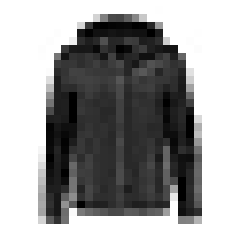

In [23]:
plt.imshow(X_train_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

Unique values of y_train data:

In [24]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

List of class names to know what exactly each number depicts

In [25]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [26]:
class_names[y_train[0]]

'Coat'

Some samples from the MNIST Fashion dataset

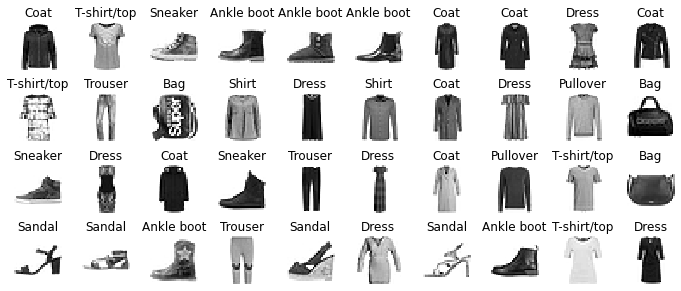

In [27]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train_normalized[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Make prediction for single instances

## Instance to predict 01 - Ankle boot

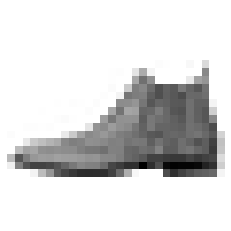

In [28]:
plt.imshow(X_test_normalized[0], cmap="binary")
plt.axis('off')
plt.show()

In [29]:
class_names[y_test[0]]

'Ankle boot'

## Instance  to predict 02 - Coat

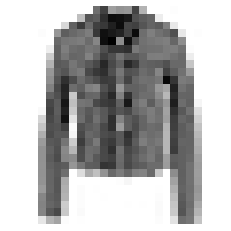

In [30]:
plt.imshow(X_test_normalized[10], cmap="binary")
plt.axis('off')
plt.show()

In [31]:
class_names[y_test[10]]

'Coat'

# Simple Model with Dropouts

Reset all state generated by Keras

In [32]:
# keras.backend.clear_session()

## Build and Train the model

Create the MCDropout class that extends the Dropout layer.

In [33]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Add Dropout layers

In [34]:
model_simple_drp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MCDropout(rate=0.2),
    keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    MCDropout(rate=0.2),
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    MCDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

Compile the model

In [35]:
model_simple_drp.compile(loss=model_params["loss"], 
                         optimizer=model_params["optimizer"], 
                         metrics=model_params["metrics"])

Train the model

In [36]:
history_simple_drp = model_simple_drp.fit(X_train_normalized, y_train, epochs=model_params["n_epochs"], 
                                          validation_data=(X_valid_normalized, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6337 - accuracy: 0.7695 - val_loss: 0.4721 - val_accuracy: 0.8286
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4829 - accuracy: 0.8212 - val_loss: 0.4522 - val_accuracy: 0.8356
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4481 - accuracy: 0.8340 - val_loss: 0.4485 - val_accuracy: 0.8380
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4225 - accuracy: 0.8441 - val_loss: 0.4047 - val_accuracy: 0.8520
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4078 - accuracy: 0.8491 - val_loss: 0.3903 - val_accuracy: 0.8616
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3952 - accuracy: 0.8531 - val_loss: 0.3962 - val_accuracy: 0.8620
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3848 - accuracy: 0.8577 - val_loss: 0.3850 - val_accuracy:

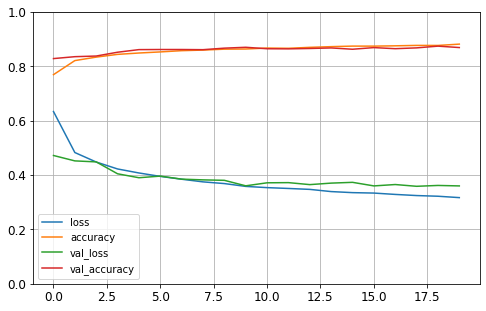

In [37]:
pd.DataFrame(history_simple_drp.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluate the model on the Test data

In [38]:
loss, accuracy = model_simple_drp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 51.6583 - accuracy: 0.8126


In [39]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 81.260


## Predictions

In [40]:
y_probas = np.stack([model_simple_drp.predict(X_test_normalized) for sample in tqdm(range(100))])

In [41]:
y_probas.shape

(100, 10000, 10)

In [42]:
def plot_predictions_distribution_for_single_instance(instance_predictions, class_names):
    plt.figure(figsize=(8,6))
    for class_i in range(0, instance_predictions.shape[-1]):
        plt.plot(instance_predictions[..., class_i], label=class_names[class_i])
    plt.grid()
    plt.legend()

### Instance - Ankle boot

Predictions for the first instance of test_X with label `Ankle boot`.

In [43]:
print("Shape of the 100 probability predictions for this instance:", np.round(y_probas[:, 0, np.newaxis], 2).shape)

Shape of the 100 probability predictions for this instance: (100, 1, 10)


View the different predictions for that instance

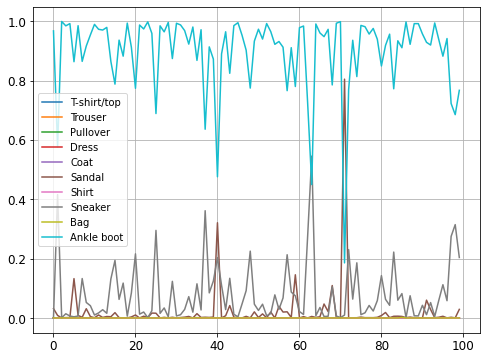

In [44]:
plot_predictions_distribution_for_single_instance(y_probas[:, 0, np.newaxis], class_names)

In [45]:
y_std = y_probas[:, 0, np.newaxis].std(axis=0)
y_std = np.round(y_std, 5)
print("Instance STD : {}".format(y_std))
max_std = y_std.max()
argmax_std = y_std.argmax()
print("Max std: {0:.5f} ({1})".format(max_std, class_names[argmax_std]))

Instance STD : [[1.0000e-05 1.0000e-05 2.0000e-05 1.1000e-04 1.0000e-05 8.7740e-02
  2.0000e-05 9.9450e-02 2.0000e-04 1.3074e-01]]
Max std: 0.13074 (Ankle boot)


In [46]:
def entropy(probs):
    """Return the prediction of a T*N*C tensor with :
        - T : the number of samples
        - N : the batch size
        - C : the number of classes
    """
    prob = probs.mean(axis=0)
    entrop = - (np.log(prob) * prob).sum(axis=1)
    return entrop


def uncertainty_best_probability(probs):
    """Return the standard deviation of the most probable class"""
    idx = probs.mean(axis=0).argmax(axis=1)

    std = probs[:, np.arange(len(idx)), idx].std(axis=0)

    return std, idx

In [47]:
entr = entropy(y_probas[:, 0, np.newaxis])
print("Entropy : {0:.4f}".format(entr[0]))

Entropy : 0.3835


In [48]:
ubp, idx = uncertainty_best_probability(y_probas[:, 0, np.newaxis])
print("Uncertainty Best Probability: {0:.4f}, class `{1}`.".format(ubp[0], class_names[idx[0]]))

Uncertainty Best Probability: 0.1307, class `Ankle boot`.


**Predict the class for this instance**

This step is critical as it is also useful to know exactly which other classes it thinks are likely.

In [49]:
instance = 0
class_index = np.argmax(y_probas[:, instance, np.newaxis].mean(axis=0))
class_prob_mean = np.max(y_probas[:, instance, np.newaxis].mean(axis=0))
class_prob_std = y_probas[:, instance, np.newaxis].std(axis=0)[0][class_index]
entr = entropy(y_probas[:, instance, np.newaxis])[0]
print("Most possible class for this instance is `{0}`.\n\t"\
      "Probability : {1:.3f}\n\tSTD: {2:.3f}\n\tEntropy: {3:.3f}".format(class_names[class_index], 
                                                                         class_prob_mean, 
                                                                         class_prob_std,
                                                                         entr))

Most possible class for this instance is `Ankle boot`.
	Probability : 0.898
	STD: 0.131
	Entropy: 0.384


### Instance - Coat

Predict the same instance again as previously with `softmax` and the `dropout` **off**. It is the same as the section above and it is presented to see the difference in the predictions.

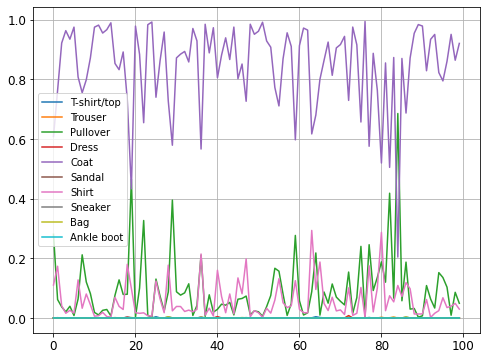

In [50]:
instance = 10
plot_predictions_distribution_for_single_instance(y_probas[:, instance, np.newaxis], class_names)

In [51]:
entr = entropy(y_probas[:, 10, np.newaxis])
print("Entropy : {0:.4f}".format(entr[0]))

Entropy : 0.5390


In [52]:
ubp, idx = uncertainty_best_probability(y_probas[:, 10, np.newaxis])
print("Uncertainty Best Probability: {0:.4f}, class `{1}`.".format(ubp[0], class_names[idx[0]]))

Uncertainty Best Probability: 0.1423, class `Coat`.


In [53]:
instance = 10
class_index = np.argmax(y_probas[:, instance, np.newaxis].mean(axis=0))
class_prob_mean = np.max(y_probas[:, instance, np.newaxis].mean(axis=0))
class_prob_std = y_probas[:, instance, np.newaxis].std(axis=0)[0][class_index]
entr = entropy(y_probas[:, instance, np.newaxis])[0]
print("Most possible class for this instance is `{0}`.\n\t"\
      "Probability : {1:.3f}\n\tSTD: {2:.3f}\n\tEntropy: {3:.3f}".format(class_names[class_index], 
                                                                         class_prob_mean, 
                                                                         class_prob_std,
                                                                         entr))

Most possible class for this instance is `Coat`.
	Probability : 0.847
	STD: 0.142
	Entropy: 0.539


## Evaluate the model on the Test data (with the probabilities this time)

Hold the predicted classes by return the maximum value from each probability estimate

In [54]:
y_proba = y_probas.mean(axis=0)

In [55]:
y_pred = np.argmax(y_proba, axis=1)

In [56]:
accuracy = np.sum(y_pred == y_test) / len(y_test)

In [57]:
print("Accuracy: %.3f" % (accuracy * 100))

Accuracy: 87.660


# Predictions on MNIST with digits

## Load the data

In [58]:
digits_mnist = keras.datasets.mnist

In [59]:
(X_train_digits, y_train_digits), (X_test_digits, y_test_digits) = digits_mnist.load_data()

In [60]:
print("Digits - X train shape:", X_train_digits.shape)
print("Digits - X test shape:", X_test_digits.shape)
print("Digits - y train shape:", X_test_digits.shape)
print("Digits - y test shape:", y_test_digits.shape)

Digits - X train shape: (60000, 28, 28)
Digits - X test shape: (10000, 28, 28)
Digits - y train shape: (10000, 28, 28)
Digits - y test shape: (10000,)


## Transform the data (Scale + 4 dimensions)

In [61]:
X_train_digits_nrm = normalize_pics(X_train_digits)
X_test_digits_nrm = normalize_pics(X_test_digits)

In [62]:
print("Digits - X train normalized shape:", X_train_digits_nrm.shape)
print("Digits - X test normalized shape:", X_test_digits_nrm.shape)
print("Digits - X test max normalized value:", X_test_digits_nrm.max())
print("Digits - X test min normalized value:", X_test_digits_nrm.min())

Digits - X train normalized shape: (60000, 28, 28)
Digits - X test normalized shape: (10000, 28, 28)
Digits - X test max normalized value: 1.0
Digits - X test min normalized value: 0.0


In [63]:
X_train_digits_nrm_cnn = X_train_digits_nrm[..., np.newaxis]
X_test_digits_nrm_cnn = X_test_digits_nrm[..., np.newaxis]

## Predictions

In [64]:
y_probas_digits = np.stack([model_simple_drp.predict(X_test_digits_nrm_cnn) for sample in tqdm(range(100))])

### Instance - 7

In [65]:
X_test_digits_nrm_instance = np.squeeze(X_test_digits_nrm_cnn[0])
print("Shape of digit instance", X_test_digits_nrm_instance.shape)
print("label:", y_test_digits[0])

Shape of digit instance (28, 28)
label: 7


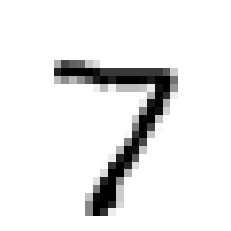

In [66]:
plt.imshow(X_test_digits_nrm_instance, cmap="binary")
plt.axis('off')
plt.show()

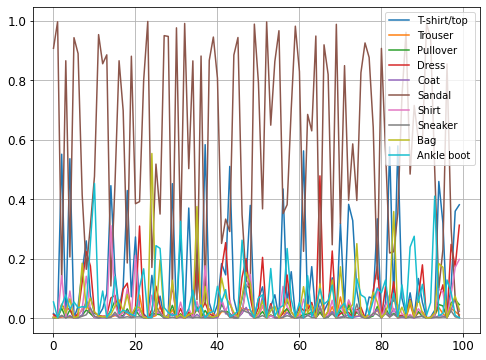

In [67]:
plot_predictions_distribution_for_single_instance(y_probas_digits[:, 0, np.newaxis], class_names)

In [68]:
entr = entropy(y_probas_digits[:, 0, np.newaxis])
print("Entropy : {0:.4f}".format(entr[0]))

Entropy : 1.4270


In [69]:
ubp, idx = uncertainty_best_probability(y_probas_digits[:, 0, np.newaxis])
print("Uncertainty Best Probability: {0:.4f}, class `{1}`.".format(ubp[0], class_names[idx[0]]))

Uncertainty Best Probability: 0.3191, class `Sandal`.


In [70]:
instance = 0
class_index = np.argmax(y_probas_digits[:, instance, np.newaxis].mean(axis=0))
class_prob_mean = np.max(y_probas_digits[:, instance, np.newaxis].mean(axis=0))
class_prob_std = y_probas_digits[:, instance, np.newaxis].std(axis=0)[0][class_index]
entr = entropy(y_probas_digits[:, instance, np.newaxis])[0]
print("Most possible class for this instance is `{0}`.\n\t"\
      "Probability : {1:.3f}\n\tSTD: {2:.3f}\n\tEntropy: {3:.3f}".format(class_names[class_index], 
                                                                         class_prob_mean, 
                                                                         class_prob_std,
                                                                         entr))

Most possible class for this instance is `Sandal`.
	Probability : 0.590
	STD: 0.319
	Entropy: 1.427


# TrustScore (experimental)

Based on the example presented [here](https://docs.seldon.io/projects/alibi/en/stable/examples/trustscore_mnist.html).

In [71]:
from alibi.confidence import TrustScore

## Dimensionality reduction

Select how to performa dimensionality reduction on the data. There are two options, one with PCA and one with an EncoderDecoder model.

In [117]:
dimensionality_reduction_method = "pca"  # Options are "ae" or "pca"

In [118]:
transformer = None

### Dimensionality reduction with PCA

Instead of using an auto-encoder, a PCA transformer will be used. The methodology below is based on [this guide](https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Image_Reconstruction_and_such.ipynb).

In [119]:
from sklearn.decomposition import PCA

In [120]:
def reshape_dataset(dataset):
    if len(dataset.shape) <= 2:
        print("Data are already 2-dimensional")
    else:
        print("Decomposing data with dimension > 2. The data will be flattened!")
        dataset = dataset.reshape(dataset.shape[0], dataset.shape[1]*dataset.shape[2])
    return dataset

In [121]:
if dimensionality_reduction_method == "pca":
    print("Flattening X_train")
    X_train_flattened = reshape_dataset(X_train_normalized)
    print("Flattening X_test")
    X_test_flattened = reshape_dataset(X_test_normalized)
    print("X_train_flattened shape: {}".format(X_train_flattened.shape))
    print("X_test_flattened shape: {}".format(X_test_flattened.shape))
    print("Transforming data with PCA")
    pca = PCA(n_components=.95)
    pca.fit(X_train_flattened)
    X_train_feats = pca.transform(X_train_flattened)
    X_test_feats = pca.transform(X_test_flattened)
    print("X_train_feats shape : {}".format(X_train_feats.shape))
    print("X_test_feats shape : {}".format(X_test_feats.shape))
    transformer = pca

Flattening X_train
Decomposing data with dimension > 2. The data will be flattened!
Flattening X_test
Decomposing data with dimension > 2. The data will be flattened!
X_train_flattened shape: (55000, 784)
X_test_flattened shape: (10000, 784)
Transforming data with PCA
X_train_feats shape : (55000, 188)
X_test_feats shape : (10000, 188)


### Dimensionaliy reduction with AutoEncoder

In [122]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model

In [123]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation=None, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(4, 4, 4))
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

In [124]:
if dimensionality_reduction_method == "ae":
    ae, enc, dec = ae_model()
    ae.summary()
    ae.fit(X_train_normalized, X_train_normalized, batch_size=128, epochs=8, validation_data=(X_valid_normalized, X_valid_normalized))
    transformer = enc

In [125]:
if dimensionality_reduction_method == "ae":
    X_train_feats = transformer.predict(X_train_normalized)
    X_test_feats = transformer.predict(X_test_normalized)

In [126]:
print("X_train_feats shape : {}".format(X_train_feats.shape))
print("X_test_feats shape : {}".format(X_test_feats.shape))

X_train_feats shape : (55000, 188)
X_test_feats shape : (10000, 188)


## Calculate TrustScores

Initialize trust scores:

In [127]:
ts = TrustScore()

The key is to fit and calculate the trust scores on the encoded instances.

In [128]:
ts.fit(X_train_feats, y_train, classes=10)

We can now calculate the trust scores and closest not predicted classes of the predictions on the test set, using the distance to the 5th nearest neighbor in each class.

Below the model's predictions are calculated as the mean of 100 predictions.

In [129]:
n_samples = 1000 # calculate the trust scores for the first 1000 predictions on the test set

y_pred = np.stack([model_simple_drp.predict(X_test_normalized[:n_samples]) for sample in tqdm(range(100))]).mean(axis=0)

In [130]:
score, closest_class = ts.score(X_test_feats[:n_samples], y_pred, k=5)

In [131]:
print("Score min : {:.2f}".format(score.min()))
print("Score max : {:.2f}".format(score.max()))

Score min : 0.74
Score max : 3.96


Let's inspect which predictions have low and high trust scores:

In [132]:
n = 5

# lowest and highest trust scores
idx_min, idx_max = np.argsort(score)[:n], np.argsort(score)[-n:]
score_min, score_max = score[idx_min], score[idx_max]
closest_min, closest_max = closest_class[idx_min], closest_class[idx_max]
pred_min, pred_max = y_pred[idx_min], y_pred[idx_max]
imgs_min, imgs_max = X_test[idx_min], X_test[idx_max]
label_min, label_max = np.argmax(y_test_cat[idx_min], axis=1), np.argmax(y_test_cat[idx_max], axis=1)

In [133]:
X_test.shape

(10000, 28, 28)

In [134]:
# model confidence percentiles
max_proba = y_pred.max(axis=1)

In [135]:
max_proba.shape

(1000,)

In [136]:
# low score high confidence examples
idx_low = np.where((max_proba>0.80) & (max_proba<0.9) & (score<1))[0][:n]
score_low = score[idx_low]
closest_low = closest_class[idx_low]
pred_low = y_pred[idx_low]
imgs_low = X_test[idx_low]
label_low = np.argmax(y_test_cat[idx_low], axis=1)

### Low Trust Scores

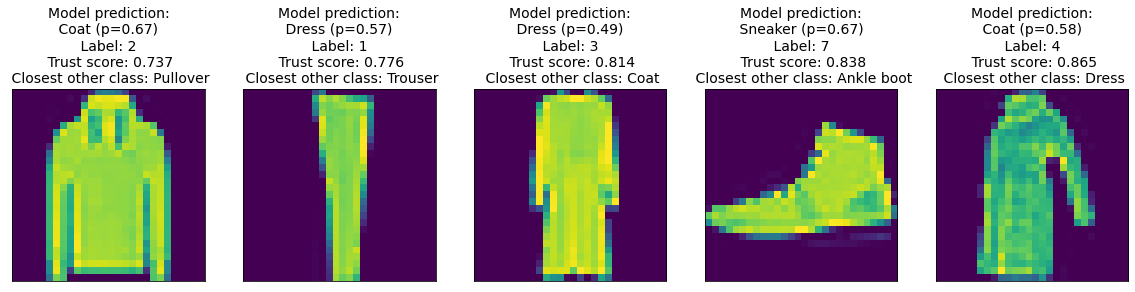

In [137]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_min[i])
    title_str = "Model prediction:\n {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}" \
              "\n Closest other class: {}".format(class_names[pred_min[i].argmax()],
                                                  pred_min[i].max(),
                                                  label_min[i], score_min[i], 
                                                  class_names[closest_min[i]])
    plt.title(title_str, fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### High TrustScores

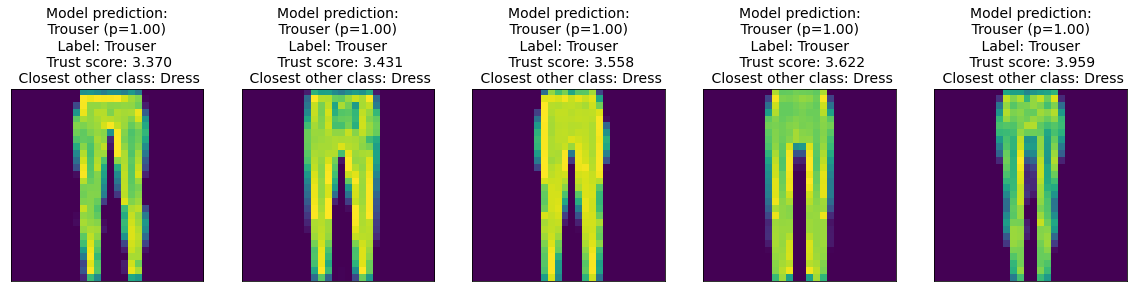

In [138]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_max[i].reshape(28, 28))
    title_str = "Model prediction:\n {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}" \
              "\n Closest other class: {}".format(class_names[pred_max[i].argmax()],
                                                  pred_max[i].max(),
                                                  class_names[label_max[i]],
                                                  score_max[i], 
                                                  class_names[closest_max[i]])
#     print(title_str)
    plt.title(title_str, fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### High model confidence, low trust score

Where trust scores really matter is when the predicted model confidence is relatively high (e.g. p?[0.8,0.9]) but the corresponding trust score is low, this can indicate samples for which the model is overconfident.The trust score provides a diagnostic for finding these examples:

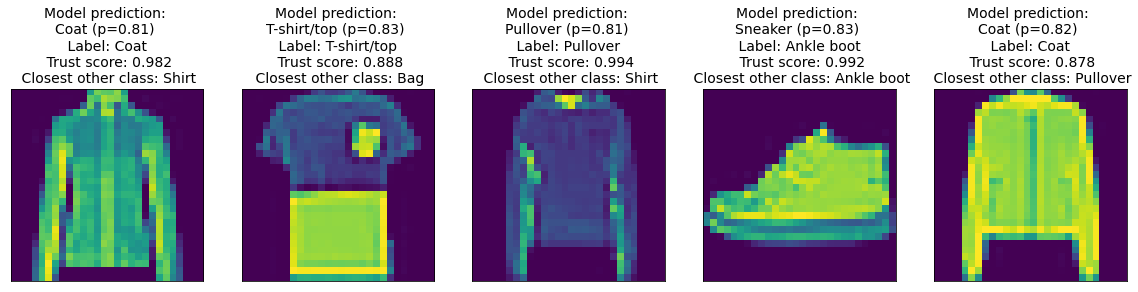

In [139]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_low[i].reshape(28, 28))
    plt.title('Model prediction: \n{} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}' \
              '\n Closest other class: {}'.format(class_names[pred_low[i].argmax()],
                                                  pred_low[i].max(),
                                                  class_names[label_low[i]], score_low[i], 
                                                  class_names[closest_low[i]]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Comparison of Trust Scores with model prediction probabilities

Compare the prediction probabilities from the classifier with the trust scores for each prediction by checking whether trust scores are better than the model's prediction probabilities at identifying correctly classified examples.

### Instance - Ankle boot

Predict the instance 0 of testset that has label `Ankle boot` with TrustScore.

In [140]:
instance = 0
score, closest_class = ts.score(X_test_feats[instance, np.newaxis], y_pred[instance, np.newaxis], k=5)

In [141]:
descrip_str = "Model prediction:\n {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}" \
              "\n Closest other class: {}".format(class_names[y_pred[instance].argmax()],
                                                  y_pred[instance].max(),
                                                  class_names[y_pred[instance].argmax()],
                                                  score[0], 
                                                  class_names[closest_class[0]])
print(descrip_str)

Model prediction:
 Ankle boot (p=0.88) 
 Label: Ankle boot 
 Trust score: 1.448
 Closest other class: Sneaker


### Instance - Coat

Predict the instance 10 of testset that has label `Coat` with TrustScore.

In [142]:
instance = 10
score, closest_class = ts.score(X_test_feats[instance, np.newaxis], y_pred[instance, np.newaxis], k=5)

In [143]:
descrip_str = "Model prediction:\n {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}" \
              "\n Closest other class: {}".format(class_names[y_pred[instance].argmax()],
                                                  y_pred[instance].max(),
                                                  class_names[y_pred[instance].argmax()],
                                                  score[0], 
                                                  class_names[closest_class[0]])
print(descrip_str)

Model prediction:
 Coat (p=0.87) 
 Label: Coat 
 Trust score: 1.265
 Closest other class: Pullover


### Instance - 7

Create a function that transforms an image instance, in order to use it for predictions. Then use it to predict an instance from MNIST-digits dataset.

In [144]:
def transform_instance(instance, transformer):
    new_instance = None
    if isinstance(transformer, PCA):
        new_instance = instance.reshape(-1,1).transpose()
        new_instance = transformer.transform(new_instance)
    else:
        new_instance = transformer.predict(instance[..., np.newaxis])
    return new_instance

In [145]:
inst_7 = np.moveaxis(X_test_digits_nrm_cnn[0], -1, 0)

In [146]:
inst_7_feats = transform_instance(inst_7, transformer)

In [147]:
inst_7_feats.shape

(1, 188)

In [148]:
inst_7_pred = model_simple_drp.predict(inst_7)

In [149]:
score, closest_class = ts.score(inst_7_feats, inst_7_pred, k=5)

In [150]:
descrip_str = "Model prediction:\n {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}" \
              "\n Closest other class: {}".format(class_names[inst_7_pred.argmax()],
                                                  inst_7_pred.max(),
                                                  class_names[inst_7_pred.argmax()],
                                                  score[0], 
                                                  class_names[closest_class[0]])
print(descrip_str)

Model prediction:
 Sandal (p=0.91) 
 Label: Sandal 
 Trust score: 0.957
 Closest other class: T-shirt/top


# View all metrics on distorted image

In [106]:
import random

In [107]:
def view_hist_class_predictions(probas):
    fig, axs = plt.subplots(1, len(class_names), sharey=True, figsize=(20,2))
    for i in range(0, len(class_names)):
        plt.subplot(1, len(class_names), i + 1)  # 1 row, 2 cols, subplot X
        axs[i].set_xlim([0, 1])
        plt.hist(probas[:, 0, i])
        axs[i].set_title(class_names[i])

Select a random instance from the testset where the class is the selected one.

In [108]:
selected_class = 3

In [109]:
class_indices = np.where(y_test == selected_class)[0]
# Get an index of a random instance of the requested class
selected_instance = class_indices[random.randint(0, len(class_indices))]

label: Dress


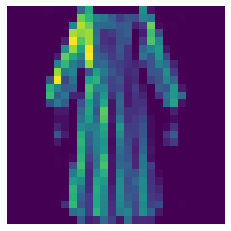

In [151]:
# View image
print("label:", class_names[y_test[selected_instance]])
plt.imshow(X_test_normalized[selected_instance])
plt.axis('off')
plt.show()

In [152]:
X_test_normalized[selected_instance].shape

(28, 28)

## View image prediction stats

In [112]:
def instance_predictions_stats(instance, transformer, class_names):
    instance_probas = np.stack([model_simple_drp.predict(instance) for sample in tqdm(range(100))])
    class_index = np.argmax(instance_probas[:, np.newaxis].mean(axis=0))
    class_prob_mean = np.max(instance_probas[:, np.newaxis].mean(axis=0))
    class_prob_std = instance_probas.std(axis=0)[0][class_index]
    entr = entropy(instance_probas)[0]
    ubp, idx = uncertainty_best_probability(instance_probas)
    
    print("Most possible class for this instance is `{0}`.\n\t"\
          "Probability : {1:.3f}\n\tSTD: {2:.3f}\n\tEntropy: {3:.3f}".format(class_names[class_index], 
                                                                             class_prob_mean, 
                                                                             class_prob_std,
                                                                             entr))
    print("\tUncertainty Best Probability: {0:.4f}, class `{1}`.".format(ubp[0], class_names[idx[0]]))
    instance_feats = transform_instance(instance, transformer)
    score, closest_class = ts.score(instance_feats, instance_probas.max(axis=0), k=5)
    print("\tTrust score: {:.3f}, Closest other class: `{}`".format(score[0], class_names[closest_class[0]]))
    view_hist_class_predictions(instance_probas)


Most possible class for this instance is `Dress`.
	Probability : 0.963
	STD: 0.043
	Entropy: 0.202
	Uncertainty Best Probability: 0.0425, class `Dress`.
	Trust score: 1.027, Closest other class: `Shirt`


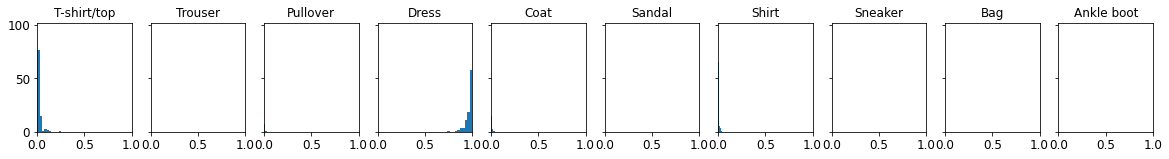

In [153]:
instance_predictions_stats(X_test_normalized[selected_instance][np.newaxis, ...], transformer, class_names)

## Distort image

In [114]:
def add_white_noise(image_in, db):
    """
    Add White noise to the image of power db. The higher the dB, the less noise effect. 
    Small values below zero (e.g. -2,-3,-4,-5) distort the image more.
    """
    width, height = image_in.shape
    mean = 0
    # Convert db to linear ratio
    snr_linear = np.power(10, db/20)
    # STD of image
    std_image = np.std(image_in)
    noise_sigma = std_image/snr_linear
    # Generate random noise
    gauss = np.random.normal(mean, noise_sigma,(width,height))
    gauss = gauss.reshape(width,height)
    noisy = image_in + gauss
    return noisy

The higher the dB, the less noise effect. 
    Small values below zero (e.g. -2,-3,-4,-5) distort the image more.

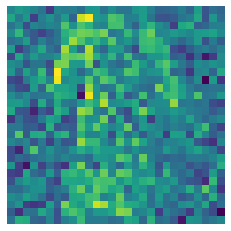

In [154]:
noisy_image = add_white_noise(X_test_normalized[selected_instance], -3)
plt.imshow(noisy_image)
plt.axis('off')
plt.show()


Most possible class for this instance is `Dress`.
	Probability : 0.932
	STD: 0.094
	Entropy: 0.333
	Uncertainty Best Probability: 0.0943, class `Dress`.
	Trust score: 1.001, Closest other class: `T-shirt/top`


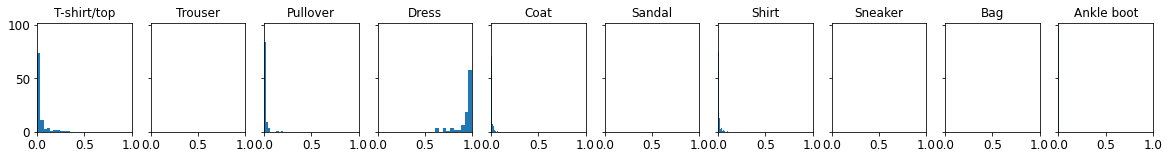

In [155]:
instance_predictions_stats(noisy_image[np.newaxis, ...], transformer, class_names)